# Extracting environmental data from `zarr` files
This notebook shows how to load `zarr` files containing environmental data for our area of interest. We will then use the locations of sea turtles observations we downloaded from OBIS to extract environmental data for points where sea turtles have been reported.

## Loading libraries

In [2]:
#Deals with zarr files
import xarray as xr
#Plotting
import matplotlib.pyplot as plt
#Deals with data frames
import pandas as pd
%matplotlib inline

In [7]:
xr.set_options(display_style = 'text')

## Loading environmental data
This dataset was provides by Eli Holmes. Source?

In [3]:
ds = xr.open_zarr("/home/jovyan/shared/marine-SDMs/INDIAN_OCEAN_025GRID_DAILY.zarr/")

We can now check the names of the environmental variables included in the dataset.

In [3]:
ds.data_vars

Data variables:
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    mlotst           (time, lat, lon) float32 dask.array<chunksize=(500, 177, 241), meta=np.ndarray>
    sla              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    so               (time, lat, lon) float32 dask.array<chunksize=(500, 177, 241), meta=np.ndarray>
    sst              (time, lat, lon) float32 dask.array<chunksize=(100, 17

## Plotting data
We will use chlorophyll (`CHL`) as an example. We will select all data for the year 2022, calculate a mean for that year and plot a map of the mean chlorophyll.

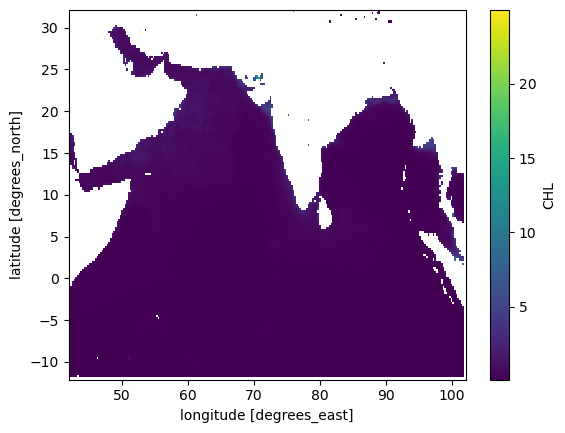

In [4]:
ds.CHL.sel(time = '2022').mean('time').plot()

We can see that chlorophyll levels are very low for most the area in the region included in the dataset. But areas near the coast show a higher chlorophyll level. 

## Loading biological data
We will now load the sea turtle observations obtained in the previous steps. We will use this data to extract data for environmental factors that are relevant to sea turtle distribution. Here, we will use `CHL` as an example. 

In [5]:
sea_turtle = pd.read_csv("/home/jovyan/ohw23_proj_marinesdms/data/raw-bio/io-sea-turtles.csv")
sea_turtle.head()

,occurrenceID,scientificName,dateIdentified,eventDate,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,individualCount,lifeStage,sex,bathymetry,shoredistance,sst,sss,date
0,1014_8853,Caretta caretta,2012-03-30T08:55:10,2012-03-30T08:55:10,9.14804,50.69448,0.11,1.0,Juvenile,NaN,35,4680,26.21,35.63,2012-03-30
1,1014_9766,Caretta caretta,2011-04-12T19:12:41,2011-04-12T19:12:41,6.40193,59.87883,0.11,1.0,Juvenile,NaN,3051,899682,28.67,35.74,2011-04-12
2,2069_333,Chelonia mydas,2016-07-24T15:18:00,2016-07-24T15:18:00,25.69900,55.78900,111.32,1.0,NaN,NaN,8,-67,28.19,38.72,2016-07-24
3,1014_8861,Caretta caretta,2012-03-31T02:43:31,2012-03-31T02:43:31,9.21307,50.82211,0.11,1.0,Juvenile,NaN,136,12208,26.21,35.65,2012-03-31
4,1014_15706,Caretta caretta,2011-05-14T17:53:55,2011-05-14T17:53:55,15.39172,55.71303,0.11,1.0,Juvenile,NaN,2784,193567,27.00,36.09,2011-05-14


## Plotting both datasets into a single map
We can visually inspect that our datasets contain data for the region of our interest.

<Axes: xlabel='decimalLongitude', ylabel='decimalLatitude'>

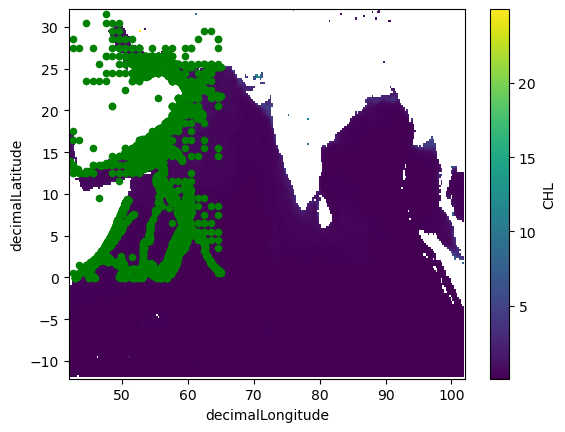

In [6]:
#Initialise figure
fig = plt.figure()
#Add a plot
ax = fig.add_subplot(111)
#We will calculate the mean chlorophyll values for 2022 and plot them
ds.CHL.sel(time = '2022').mean('time').plot(ax = ax)
#We will now plot the sea turtle data as green dots
sea_turtle.plot.scatter(y = 'decimalLatitude', x = 'decimalLongitude', ax = ax, marker = 'o', color = 'green')

## Extracting environmental data
We will now use the coordinates (i.e., lat/lon pairs) of the sea turtle locations to extract environmental data.

In [7]:
#We create data arrays with latitude and longitude values for sea turtle observation
lat = xr.DataArray(sea_turtle.decimalLatitude)
lon = xr.DataArray(sea_turtle.decimalLongitude)

We will now use these coordinates to extract `CHL` data for all years. Note that we use `nearest` as method because our environmental data is gridded and it uses the centre of the grid cell as the coordinate to be matched. 

In [8]:
env_turtles = ds.CHL.sel(lat = lat, lon = lon, method = 'nearest')

We can check what the data looks like by simply calling the `env_turtles` variable.

In [9]:
env_turtles

<xarray.DataArray 'CHL' (time: 16071, dim_0: 13210)>
dask.array<transpose, shape=(16071, 13210), dtype=float32, chunksize=(100, 13210), chunktype=numpy.ndarray>
Coordinates:
    lat      (dim_0) float32 9.25 6.5 25.75 9.25 15.5 ... 24.75 25.75 24.75 15.5
    lon      (dim_0) float32 50.75 60.0 55.75 50.75 ... 53.0 55.75 53.0 55.5
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 ... 13204 13205 13206 13207 13208 13209
Attributes:
    _ChunkSizes:                [1, 256, 256]
    ancillary_variables:        flags CHL_uncertainty
    coverage_content_type:      modelResult
    input_files_reprocessings:  Processors versions: MODIS R2022.0NRT/VIIRSN ...
    long_name:                  Chlorophyll-a concentration - Mean of the bin...
    standard_name:              mass_concentration_of_chlorophyll_a_in_sea_water
    type:                       surface
    units:                      milligram m-3
    valid_max:                  1000.0
    valid_min:                  0.0

This dataset contains `CHL` data for all coordinate pairs across all times. We will now select a single date (`2022-01-01`) and turn the results into a data frame.

In [11]:
chl_2022_01_01 = env_turtles.sel(time = '2022-01-01').to_dataframe()
chl_2022_01_01

,lat,lon,time,CHL
dim_0,,,,
0,9.25,50.75,2022-01-01,0.398237
1,6.50,60.00,2022-01-01,0.196541
2,25.75,55.75,2022-01-01,1.091021
3,9.25,50.75,2022-01-01,0.398237
4,15.50,55.75,2022-01-01,0.508613
...,...,...,...,...
13205,19.75,61.50,2022-01-01,0.671600
13206,24.75,53.00,2022-01-01,0.545474
13207,25.75,55.75,2022-01-01,1.091021


We could save this information to our local machine with just one line (see below). But we probably need to match the dates to coordinates and only keep the data we need.

In [ ]:
chl_2022_01_01.to_csv('chl_2022_01_01.csv')